<a href="https://colab.research.google.com/github/pitapatat/Data_Analysis_Visualization/blob/main/%5BDA%5D_video_game_sales_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

## raw_data
data = '/content/drive/MyDrive/Datasets/vgames2.csv'
##kaggle_data
kdata = '/content/drive/MyDrive/Datasets/vgsales.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



|feature|description|
|:---:|-----|
|Rank | Ranking of overall sales |
| Name | The games name|
| Platform | Platform of the games release (i.e. PC,PS4, etc.) |
| Year | Year of the game's release|
| Genre | Genre of the game|
| Publisher | Publisher of the game|
| NA_Sales | Sales in North America (in millions)|
| EU_Sales | Sales in Europe (in millions)|
| JP_Sales | Sales in Japan (in millions)|
| Other_Sales | Sales in the rest of the world (in millions)|
| Global_Sales | Total worldwide sales |
reference https://www.kaggle.com/gregorut/videogamesales

#### 라이브러리

In [2]:
### 한글깨짐방지
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [3]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
sys_font = fm.findSystemFonts()
#[f for f in sys_font if 'Nanum' in f]

In [4]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size = 10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumBarunGothic


In [5]:
## library
import time 
import pandas as pd
import numpy as np

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import missingno as msno
import re

import warnings
warnings.filterwarnings('ignore')

# figure size 크게 변환
from matplotlib import rcParams

In [6]:
df = pd.read_csv(data)    # aib data
dfk = pd.read_csv(kdata)  # kaggle data 


# Video-game Sales(_kaggle data) 
- 데이터 시각화 중심 

In [7]:
print(f"shape: {dfk.shape}")
dfk.head(3)

shape: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


In [8]:
#dfk.info()
#dfk.columns #['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
dfk.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


- 평균비교하면 NA > EU> JP> Other, 특히 NA 는 상위 50, 최대값이 유별나게 큰 편
- year: 1980 - 2020, 결측치 존재

In [9]:
dfk.describe(include = 'object')

,Name,Platform,Genre,Publisher
count,16598,16598,16598,16540
unique,11493,31,12,578
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts
freq,12,2163,3316,1351


- Platform :  unique = 31
- genre: unique = 12 
- publisher : 결측치 존재

In [10]:
# 결측치 
def missing_value(dfk):
    missing_cols = [(col, dfk[col].isnull().sum()) for col in dfk.columns if dfk[col].isnull().sum() != 0]
    #msno.matrix(dfk, figsize = (17,12))
    #print(missing_cols)
    missing_val = pd.DataFrame(missing_cols, columns = ['column','num of missing values'])
    return missing_val

missing_value(dfk)

,column,num of missing values
0,Year,271
1,Publisher,58


In [11]:
# 중복치 확인
dfk.duplicated().sum()

# 타입 확인
dfk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


## 결측치 보완
1. Year 
    - 결측치 데이터들을 살펴보면 platform, genre 등을 통해 연도 유추 가능
    - 뿐만아니라 게임 데이터는 시간에 따라 사용하는 플랫폼도 변화하는 추세이므로 
    - 플랫폼을 기준으로 (사용) 연도의 평균을 계산하여 결측값을 보완함

2. Publisher
    - 'unknown' 이라는 별도의 category를 설정해 분류 

### Year

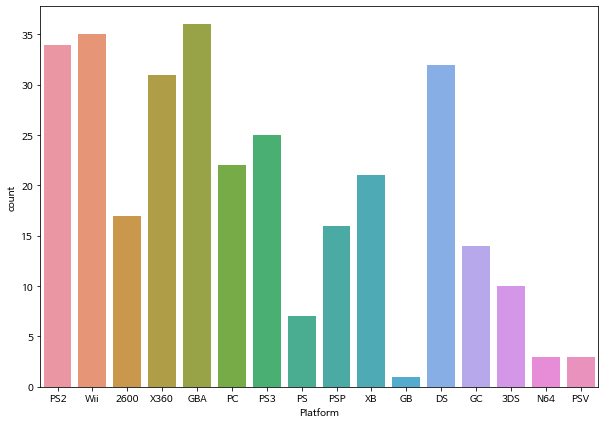

In [13]:
## 결측치 포함 데이터
dfk_null = dfk[dfk.isnull().any(axis = 1) == True]
# 결측치 데이터들의 platform 분포
plt.figure(figsize = (10,7))
sns.countplot(dfk_null.Platform)

In [14]:
# 플랫폼- 연도별 변화량(추이)를 대충 가늠할 수 있음
dfk.pivot_table(columns = ['Year'], index = ['Platform'], values =['Global_Sales']).stack().unstack().tail(10)

Global_Sales                                                          \
Year           1980.0 1981.0 1982.0 1983.0 1984.0 1985.0 1986.0 1987.0 1988.0   
Platform                                                                        
SAT               NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
SCD               NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
SNES              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
TG16              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
WS                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Wii               NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
WiiU              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
X360              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
XB                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
XOne              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                 ...                                                    \
Year     1989.0  ...    2009.0    2010.0    2011.0    2012.0    2013.0   
Platform         ...                                                     
SAT         NaN  ...       NaN       NaN       NaN       NaN       NaN   
SCD         NaN  ...       NaN       NaN       NaN       NaN       NaN   
SNES        NaN  ...       NaN       NaN       NaN       NaN       NaN   
TG16        NaN  ...       NaN       NaN       NaN       NaN       NaN   
WS          NaN  ...       NaN       NaN       NaN       NaN       NaN   
Wii         NaN  ...  0.647508  0.518898  0.433403  0.711562  0.780000   
WiiU        NaN  ...       NaN       NaN       NaN  0.557500  0.520000   
X360        NaN  ...  0.698555  0.939835  0.704466  0.951698  1.194800   
XB          NaN  ...       NaN       NaN       NaN       NaN       NaN   
XOne        NaN  ...       NaN       NaN       NaN       NaN  0.978947   

                                                      
Year        2014.0    2015.0    2016.0 2017.0 2020.0  
Platform                                              
SAT            NaN       NaN       NaN    NaN    NaN  
SCD            NaN       NaN       NaN    NaN    NaN  
SNES           NaN       NaN       NaN    NaN    NaN  
TG16           NaN       NaN       NaN    NaN    NaN  
WS             NaN       NaN       NaN    NaN    NaN  
Wii       0.740000  0.387500       NaN    NaN    NaN  
WiiU      0.726129  0.585000  0.329000    NaN    NaN  
X360      0.560308  0.326250  0.103750    NaN    NaN  
XB             NaN       NaN       NaN    NaN    NaN  
XOne      0.859508  0.729873  0.229074    NaN    NaN  

[10 rows x 39 columns]

In [15]:
# 결측치가 있는 값들의 platform 
plaforms = dfk_null.Platform.values
# 해당 platform의 평균 연도 
plaform_year_mean = pd.DataFrame(dfk.groupby(['Platform'])['Year'].mean().round(0))

# 결측치 매핑
dfk.loc[dfk['Year'].isnull(), 'Year'] = dfk['Platform'].map(plaform_year_mean.Year)
# 결측값 확인
dfk.Year.isnull().sum()

0

### Publisher

In [16]:
dfk.loc[dfk['Publisher'].isnull(), 'Publisher'] = dfk['Publisher'].fillna('unknown')
dfk.Publisher.isnull().sum()

0

## EDA

In [17]:
dfk.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [18]:
dfk_year_region = dfk.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()

dfk_year_platform = dfk.pivot_table(index = ['Year'], columns = ['Platform'], values = ['Global_Sales'])
dfk_year_genre = dfk.pivot_table(index = ['Year'], columns = ['Genre'], values = ['Global_Sales'])

### 연도별 게임 판매량 추이
- 지역별/장르별/플랫폼별

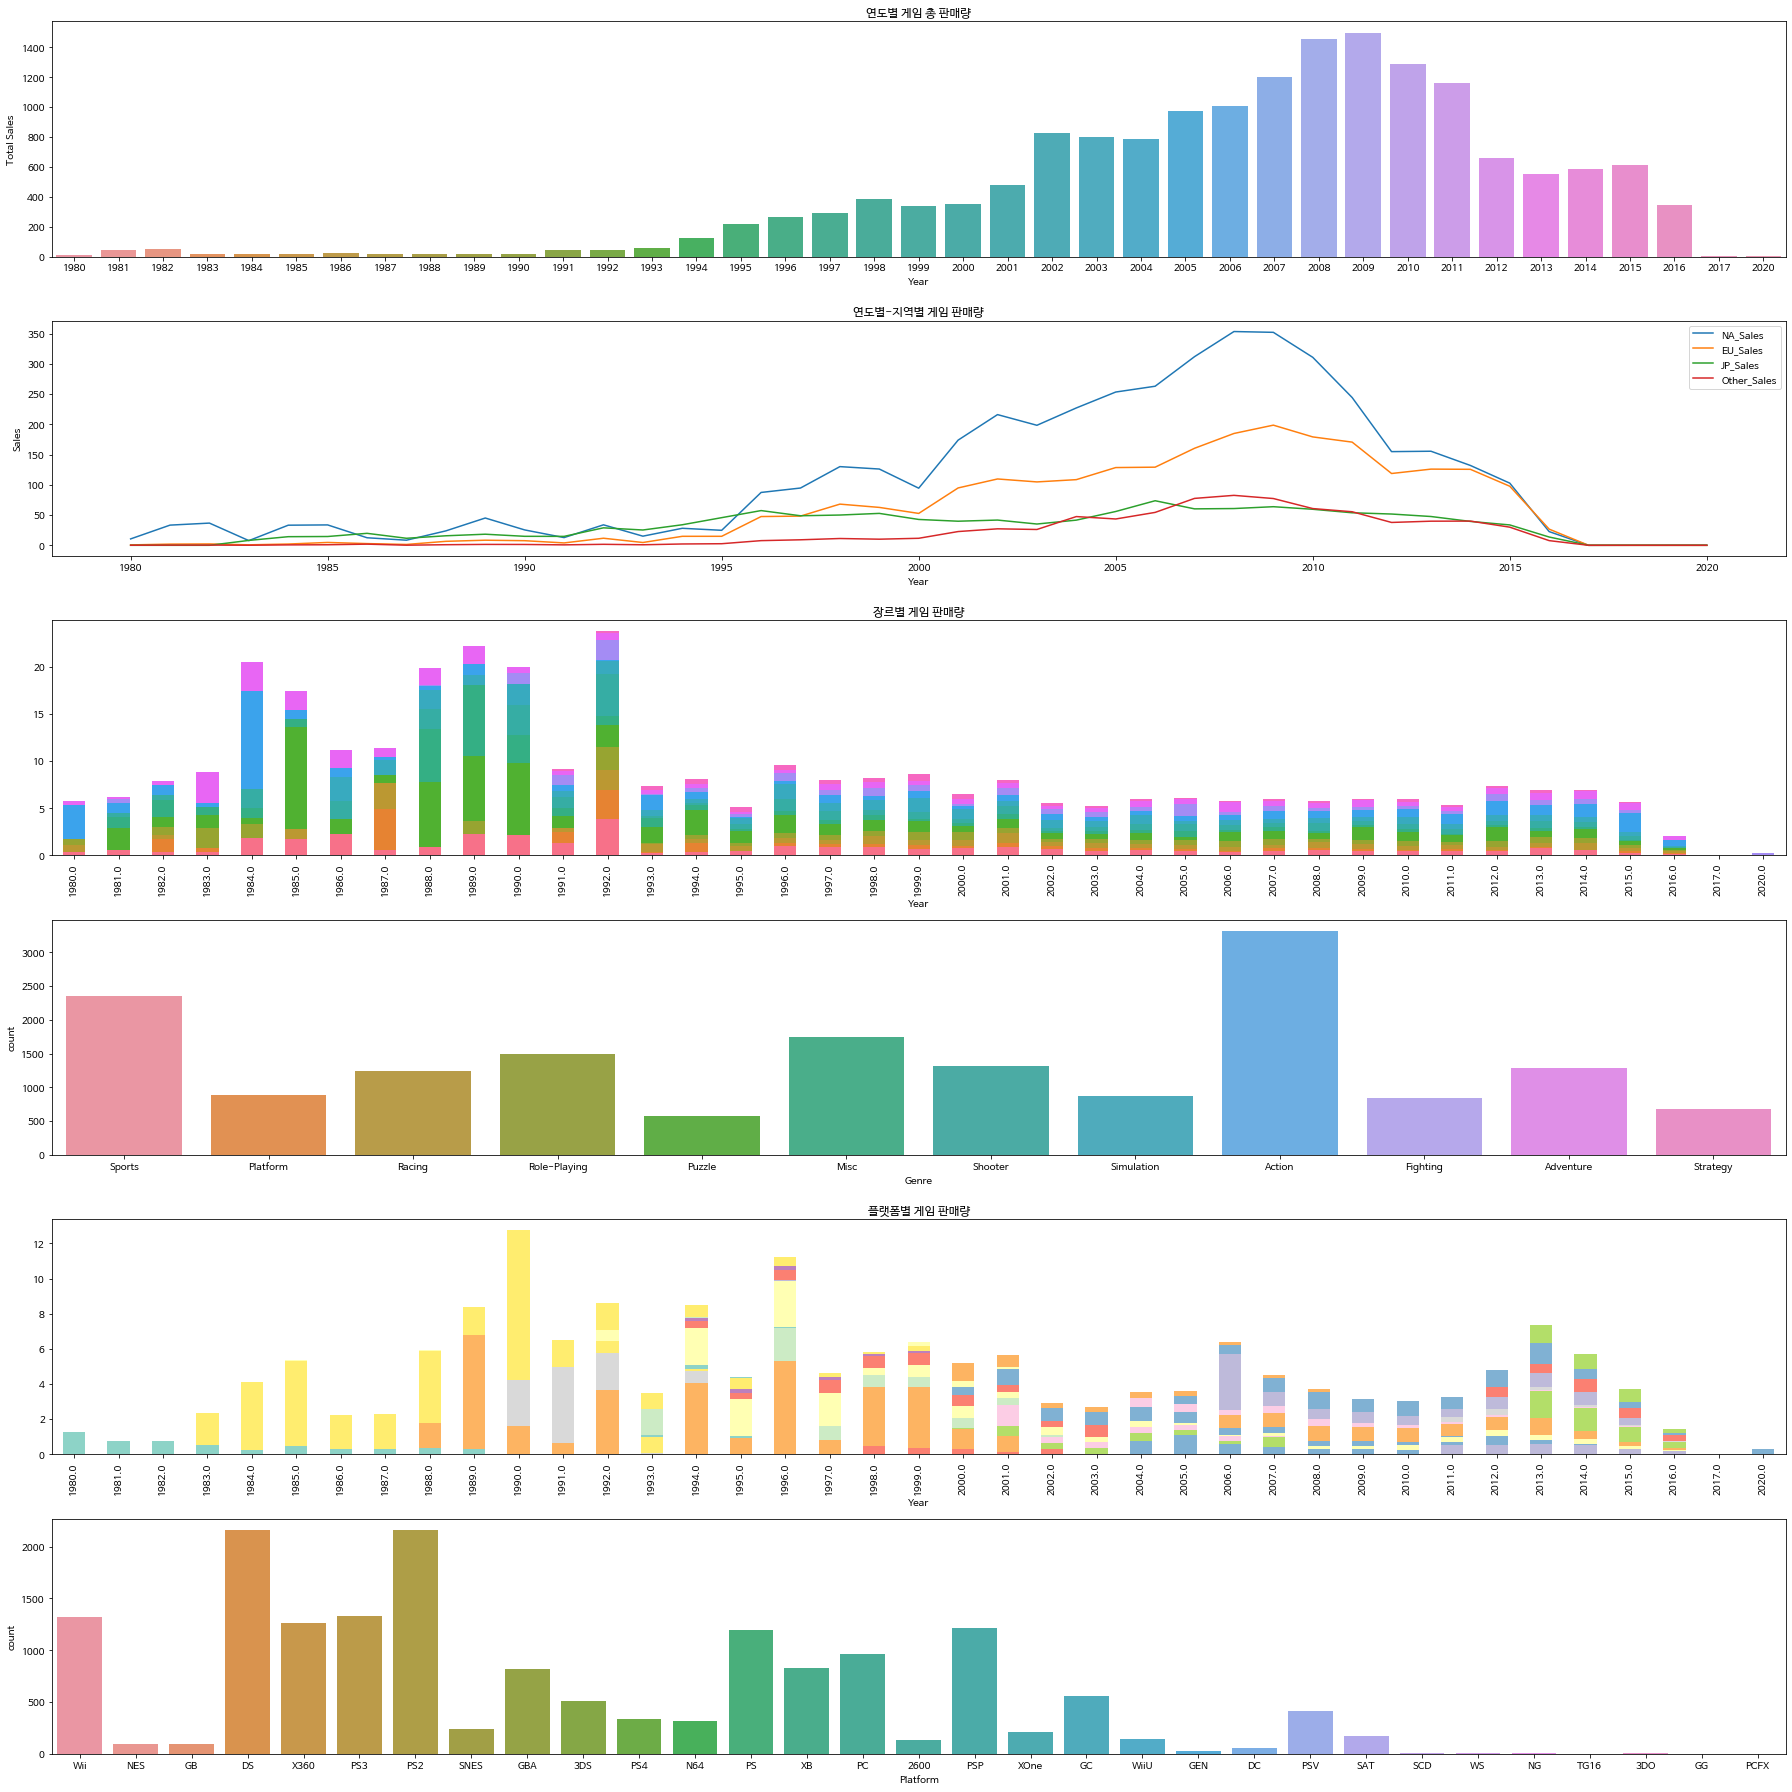

In [21]:
# Year -- .to_datetime
dfk['Year'] = pd.to_datetime(dfk.Year, format = '%Y').dt.year

# 연도별/ 수치데이터 시각화
fig, axes = plt.subplots(6,1, figsize = (25,25))
ax = axes.flatten()

ax[0].set_title("연도별 게임 총 판매량")
sns.countplot(x = 'Year', data = dfk, ax = ax[0])
ax[0].set_ylabel('Total Sales')

ax[1].set_title("연도별-지역별 게임 판매량")
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'NA_Sales', ax=ax[1], label = 'NA_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'EU_Sales', ax=ax[1], label = 'EU_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'JP_Sales', ax=ax[1], label ='JP_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'Other_Sales', ax=ax[1], label = 'Other_Sales')
ax[1].legend()
ax[1].set_ylabel('Sales')

ax[2].set_title("장르별 게임 판매량")
qualitative_colors = sns.color_palette("husl", 12)
dfk_year_genre.plot.bar(stacked = True, ax = ax[2], color = qualitative_colors)
sns.countplot(x = 'Genre', data = dfk, ax = ax[3])
ax[2].get_legend().remove()

ax[4].set_title("플랫폼별 게임 판매량")
qualitative_colors = sns.color_palette("Set3", 32)
dfk_year_platform.plot.bar(stacked = True, ax = ax[4], color = qualitative_colors)
sns.countplot(x = 'Platform', data = dfk, ax = ax[5])
ax[4].get_legend().remove()

plt.tight_layout()
plt.show();

## 출고량이 높은 게임 

* 미국 - (총) 출고량 TOP 10 

In [25]:
# 총 판매량 기준 출고량 top10 == 미국 top10
dfk.sort_values(by = 'Global_Sales', ascending = False).head(10)  # == (by = 'NA_Sales')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


* 유럽 - (총) 출고량 TOP 10 

In [31]:
dfk.sort_values(by = 'EU_Sales', ascending = False).head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
10,11,Nintendogs,DS,2005,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.76
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
19,20,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,Nintendo,4.75,9.26,4.16,2.05,20.22
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
14,15,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.09,8.59,2.53,1.79,22.00


* 일본 - (총) 출고량 TOP 10 

In [28]:
dfk.sort_values(by = 'JP_Sales', ascending = False).head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
12,13,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9.00,6.18,7.20,0.71,23.10
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
20,21,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6.42,4.52,6.04,1.37,18.36
26,27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
25,26,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,Nintendo,6.06,3.90,5.38,0.50,15.85
41,42,Animal Crossing: Wild World,DS,2005,Simulation,Nintendo,2.55,3.52,5.33,0.88,12.27
27,28,Brain Age 2: More Training in Minutes a Day,DS,2005,Puzzle,Nintendo,3.44,5.36,5.32,1.18,15.30
214,215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,Capcom,0.00,0.00,4.87,0.00,4.87


* 기타 지역 - (총) 출고량 TOP 10 

In [29]:
dfk.sort_values(by = 'Other_Sales', ascending = False).head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
17,18,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
47,48,Gran Turismo 4,PS2,2004,Racing,Sony Computer Entertainment,3.01,0.01,1.10,7.53,11.66
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
348,349,Pro Evolution Soccer 2008,PS2,2007,Sports,Konami Digital Entertainment,0.05,0.00,0.64,2.93,3.63
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
10,11,Nintendogs,DS,2005,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.76


### 지역별 TOP 10 시각화
- 장르별/플랫폼별/publisher

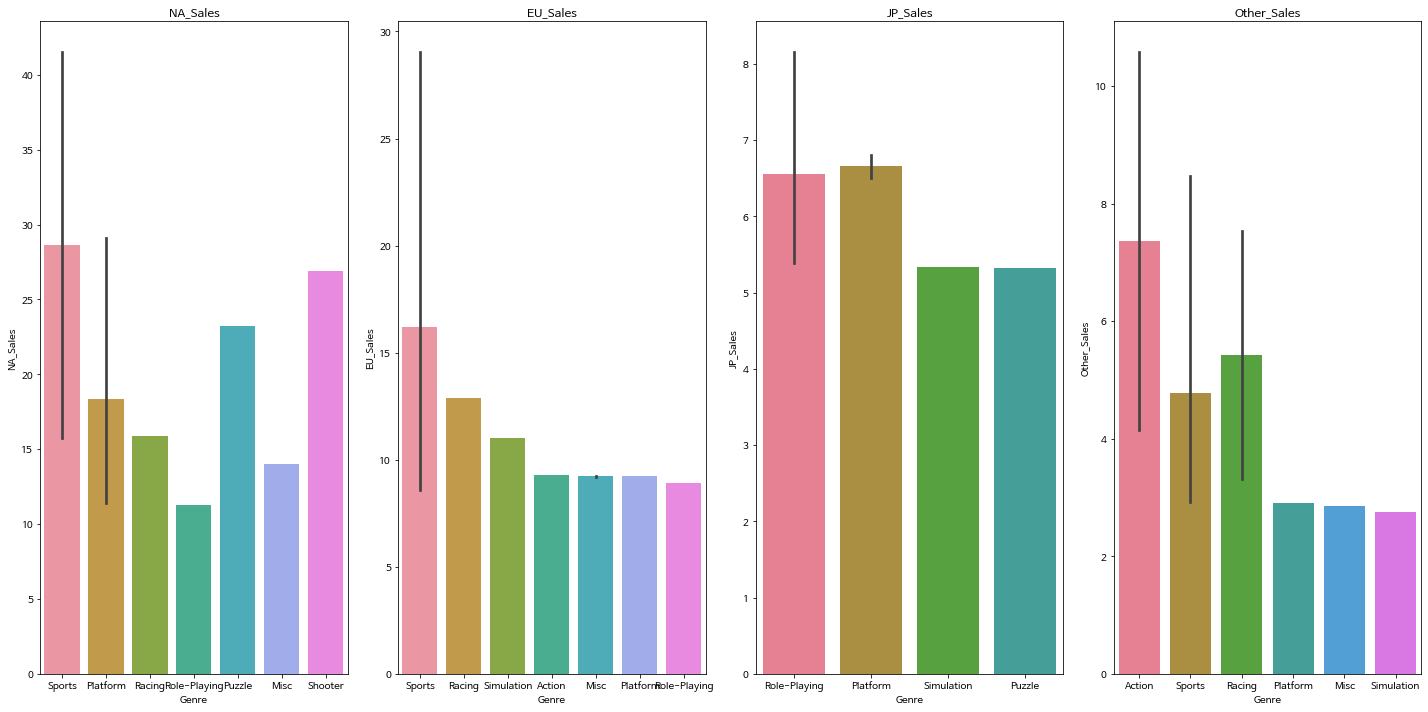

In [62]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("husl")

sns.barplot(y = 'NA_Sales', x = 'Genre',data= dfk.sort_values(by = 'Global_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Genre',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Genre',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Genre',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])

ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')

plt.tight_layout()



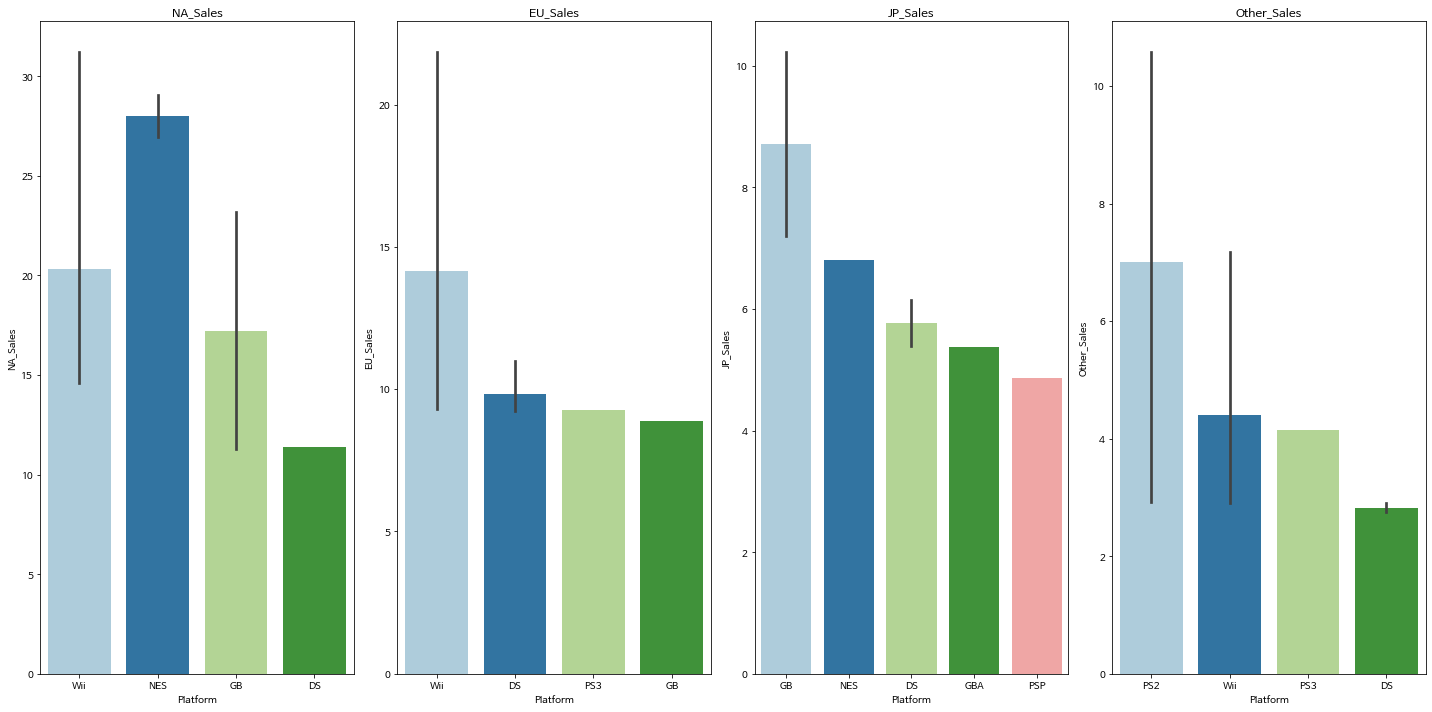

In [60]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("Paired")

sns.barplot(y = 'NA_Sales', x = 'Platform',data= dfk.sort_values(by = 'Global_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Platform',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Platform',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Platform',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])

ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')

plt.tight_layout()


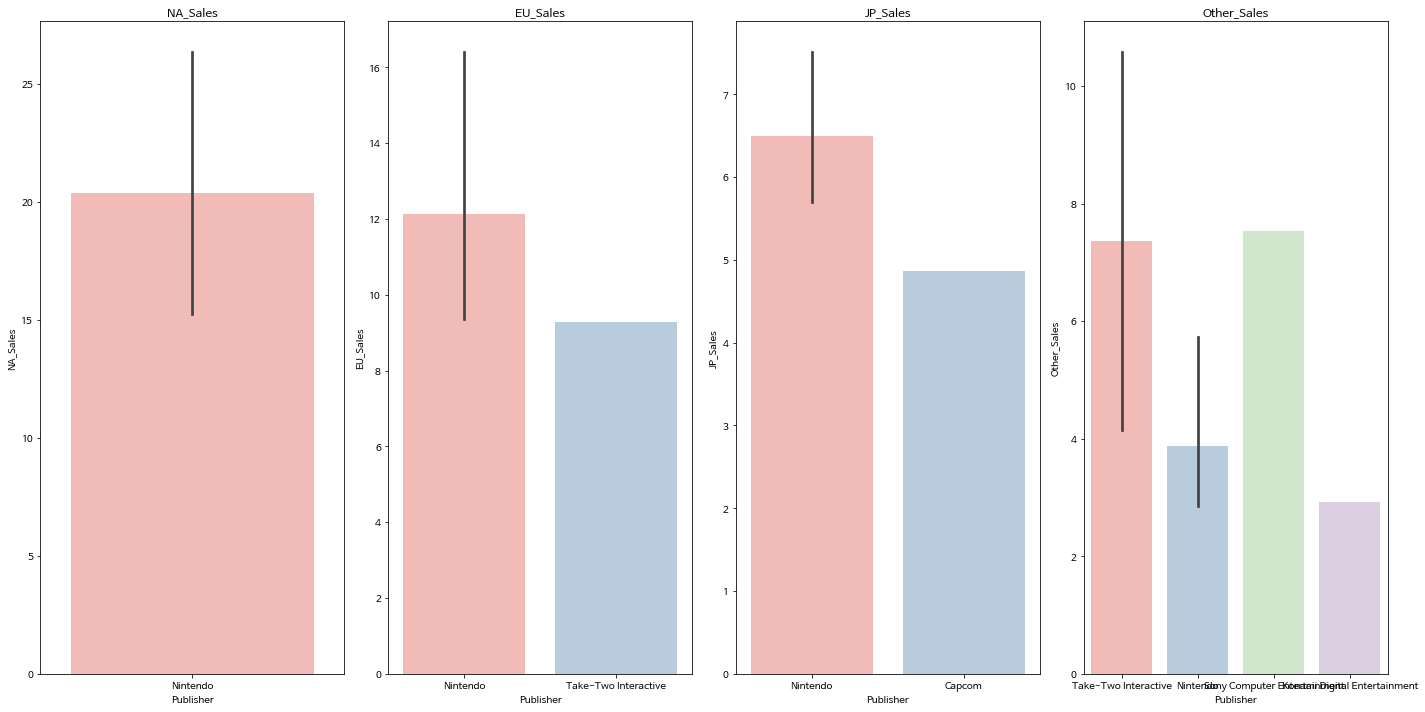

In [61]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("Pastel1")

sns.barplot(y = 'NA_Sales', x = 'Publisher',data= dfk.sort_values(by = 'Global_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Publisher',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Publisher',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Publisher',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])

ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')

plt.tight_layout()

### 장르별-지역별

#################   pd.melt   ####################

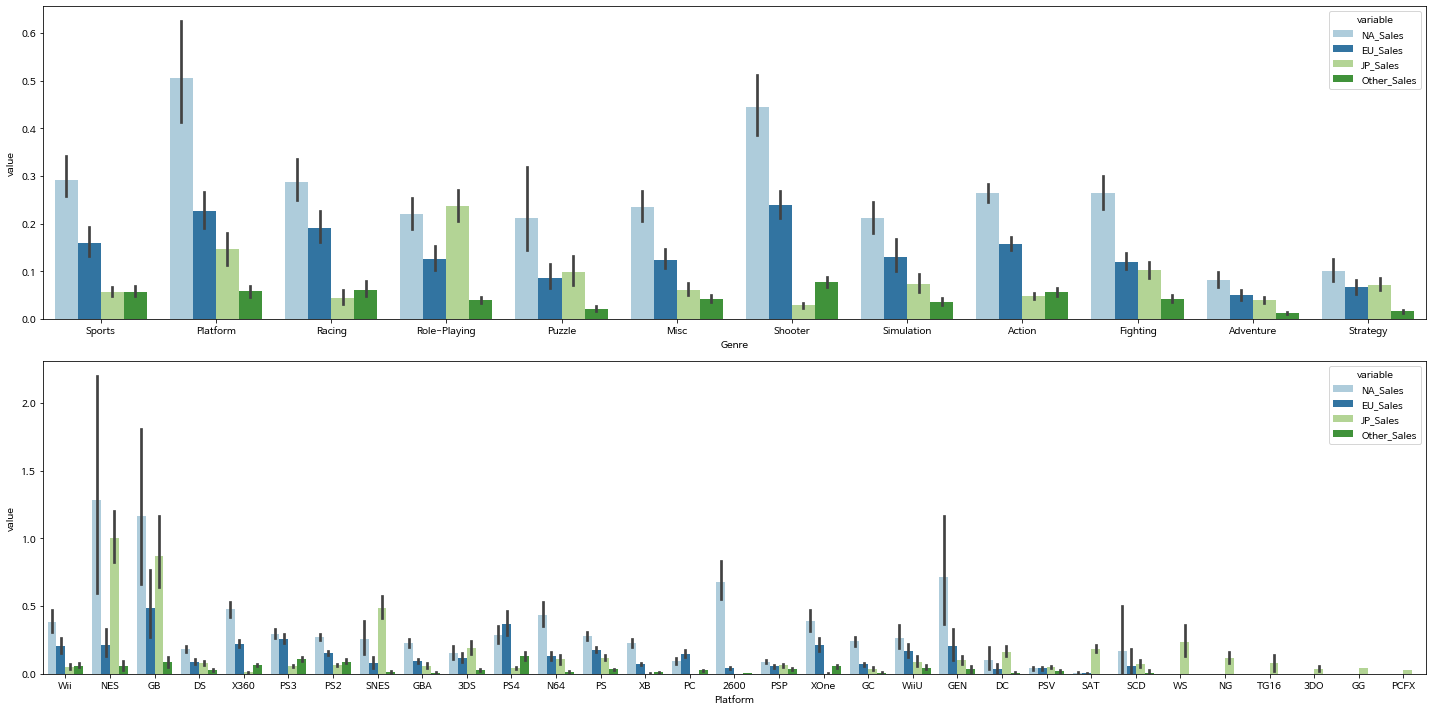

In [222]:
#dfk.groupby(['Genre']).sum()
gen_melt = pd.melt(dfk, id_vars = ['Genre'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
plat_melt = pd.melt(dfk, id_vars = ['Platform'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
pub_melt = pd.melt(dfk, id_vars = ['Publisher'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])

fig, ax = plt.subplots(2,1,figsize = (20,10))
sns.set_palette('Paired')
sns.barplot(x = 'Genre', y = 'value', hue = 'variable', data =gen_melt, ax = ax[0])
sns.barplot(x = 'Platform', y = 'value', hue = 'variable', data =plat_melt, ax = ax[1])

plt.tight_layout()
plt.show();